<a href="https://colab.research.google.com/github/shoboske/wine-quality-deep-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip3 install ucimlrepo scikit-learn pandas numpy matplotlib tensorflow keras >/dev/null 2>&1

In [3]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# fetch dataset
wine_quality = fetch_ucirepo(id=186)
red_wine = wine_quality.data.original.query('color == "red"')
white_wine = wine_quality.data.original.query('color == "white"')

columns_to_drop = ['quality', 'color']

num_classes = 11
X_red = red_wine.drop(columns=columns_to_drop)
y_red = tf.keras.utils.to_categorical(red_wine['quality'], num_classes=num_classes)

X_white = white_wine.drop(columns=columns_to_drop)
y_white = tf.keras.utils.to_categorical(white_wine['quality'], num_classes=num_classes)


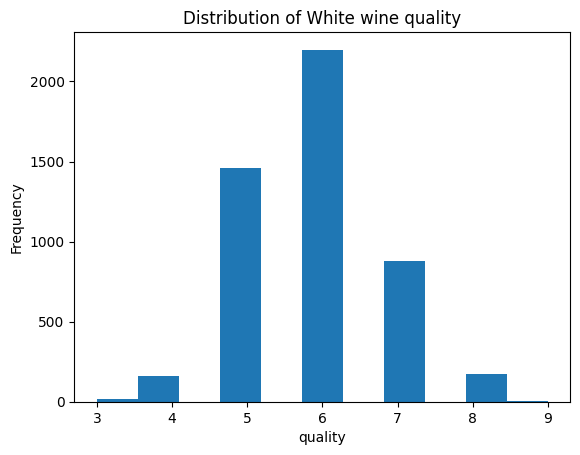

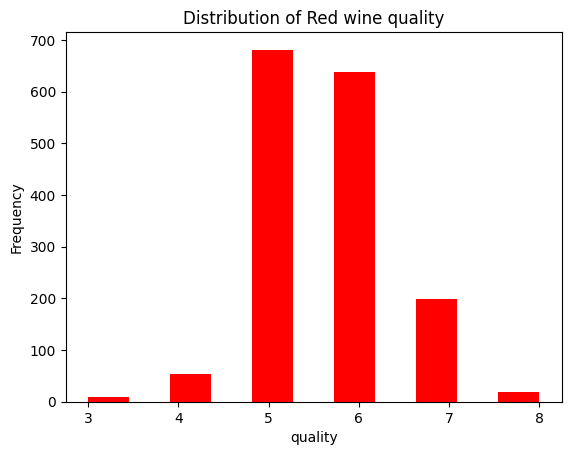

In [9]:
import matplotlib.pyplot as plt

# Assuming 'X_white' is your DataFrame
# Select a column to plot the distribution for (e.g., 'fixed_acidity')
column_to_plot = 'quality'

# Create the histogram
plt.hist(white_wine[column_to_plot], bins=11)  # Adjust the number of bins as needed
# plt.hist(red_wine[column_to_plot], bins=11, label='Red')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.title(f'Distribution of White wine {column_to_plot}')

# Display the plot
plt.show()

print()
print()

plt.hist(red_wine[column_to_plot], bins=11, label='Red', color='red')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.title(f'Distribution of Red wine {column_to_plot}')
plt.show()


In [10]:
import matplotlib.pyplot as plt
def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def std_deviation_score(X, y=None):
    return np.std(X, axis=0)

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import concurrent.futures
import tensorflow as tf
from imblearn.over_sampling import SMOTE

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.2, random_state=42)

# Create a Pipeline for feature selection and scaling
# Define the pipeline steps
pipeline_red = Pipeline([
    ('selector', SelectKBest(score_func=std_deviation_score, k=7)),
    ('scaler', StandardScaler()),
])

pipeline_white = Pipeline([
    ('selector', SelectKBest(score_func=std_deviation_score, k=8)),
    ('scaler', StandardScaler()),
])


# Fit and transform the pipeline on the training data (for both red and white wine)
X_red_train_processed = pipeline_red.fit_transform(X_red_train, y_red_train)
X_white_train_processed = pipeline_white.fit_transform(X_white_train, y_white_train)

# Transform the test data (for both red and white wine)
X_red_test_processed = pipeline_red.transform(X_red_test)
X_white_test_processed = pipeline_white.transform(X_white_test)

In [94]:
# Get the indices of selected features from SelectKBest
selected_feature_indices_red = pipeline_red['selector'].get_support(indices=True)
selected_feature_indices_white = pipeline_white['selector'].get_support(indices=True)

# Get the names of the selected features
selected_feature_names_red = X_red.columns[selected_feature_indices_red]
selected_feature_names_white = X_white.columns[selected_feature_indices_white]


# Print the feature names and their loadings on each component
print("Selected Features (Red Wine):")
for j,data in enumerate(selected_feature_names_red):
    print(f'- {data}')

print("\n\n")

print("Selected Features (White Wine):")
for j,data in enumerate(selected_feature_names_white):
    print(f'- {data}')

Selected Features (Red Wine):
- fixed_acidity
- volatile_acidity
- citric_acid
- residual_sugar
- free_sulfur_dioxide
- total_sulfur_dioxide
- alcohol



Selected Features (White Wine):
- fixed_acidity
- citric_acid
- residual_sugar
- free_sulfur_dioxide
- total_sulfur_dioxide
- pH
- sulphates
- alcohol


Red wine model training graph


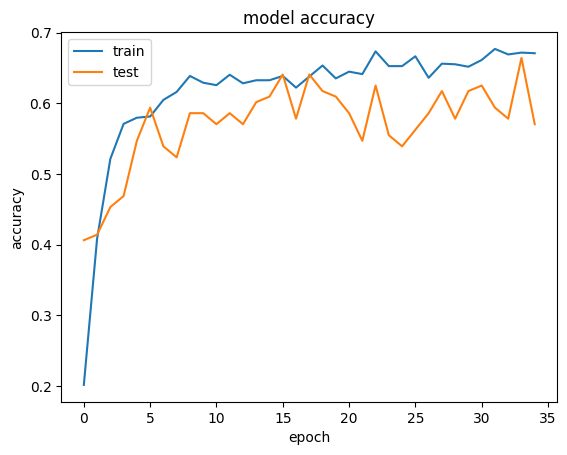

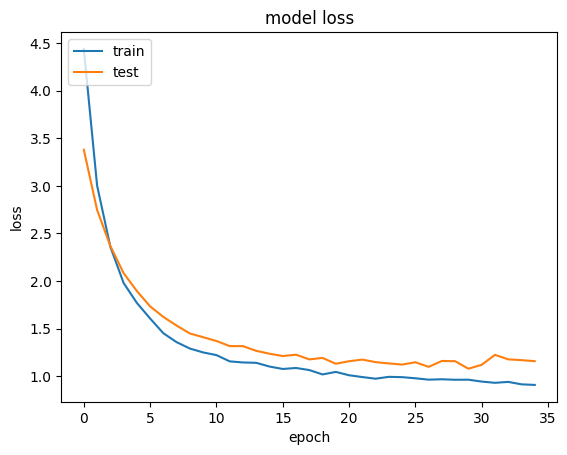




White wine model training graph


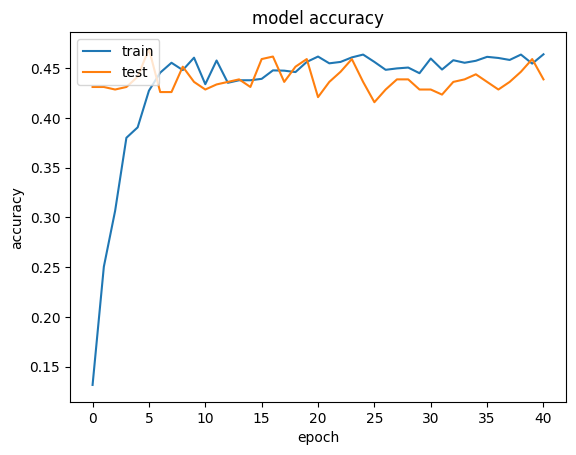

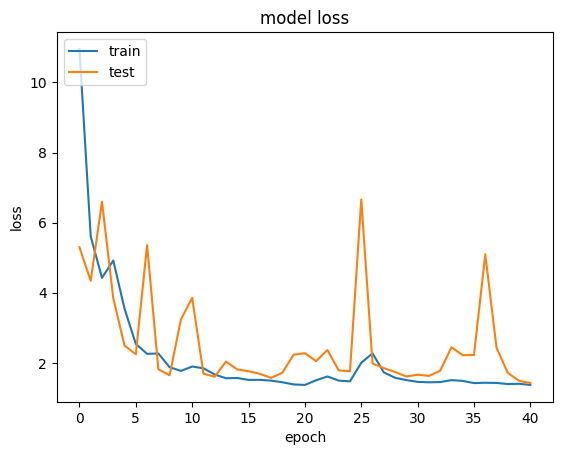

In [109]:

# Red Wine Model
red_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_red_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(50, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(40, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(40, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(40, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
     name="red-wine"
)

# White Wine Model (similar structure, adjust input shape)
white_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_white_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(80, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(80, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
    name="white-wine"
)

callback_red = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
callback_white = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, mode='min')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

optimizer_red = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_white = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile models (choose appropriate optimizer, loss, metrics)
red_wine_model.compile(optimizer=optimizer_red, loss=loss_fn, metrics=['accuracy'])
white_wine_model.compile(optimizer=optimizer_white, loss=loss_fn, metrics=['accuracy', 'mse'])

# Train the models
def train_model(model, X_train, y_train, **kwargs):
    return model.fit(X_train, y_train, **kwargs)

# Train the models concurrently using ThreadPoolExecutor so that both models are trained at the same time
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the training tasks for both models
    red_wine_future = executor.submit(train_model,
                                      red_wine_model,
                                      X_red_train_processed,
                                      y_red_train,
                                      batch_size=32, epochs=100,
                                      validation_split=0.1, validation_freq=1,
                                      callbacks=[callback_red], verbose=0)
    white_wine_future = executor.submit(train_model,
                                        white_wine_model,
                                        X_white_train_processed,
                                        y_white_train,
                                        batch_size=64,epochs=100,
                                        validation_split=0.1,
                                        validation_freq=1,
                                        callbacks=[callback_white], verbose=0)

    # Get the results (history objects)
    red_wine_history = red_wine_future.result()
    white_wine_history = white_wine_future.result()

print("Red wine model training graph")
plot_graph(red_wine_history)

print("\n\n")

print("White wine model training graph")
plot_graph(white_wine_history)

In [110]:
# Evaluate the model (you can use various metrics like accuracy, precision, recall, etc.)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Predictions for red and white wine
y_red_wine_pred = red_wine_model.predict(X_red_test_processed)  # Predictions for red wine
y_white_wine_pred = white_wine_model.predict(X_white_test_processed) # Predictions for white wine

# Convert predictions to class labels (if necessary)
y_red_wine_pred_classes = np.argmax(y_red_wine_pred, axis=1)
y_white_wine_pred_classes = np.argmax(y_white_wine_pred, axis=1)

# Convert y_red_test to multiclass format to match y_red_wine_pred_classes
y_red_test_classes = np.argmax(y_red_test, axis=1)
# Convert y_white_test to multiclass format to match y_white_wine_pred_classes
y_white_test_classes = np.argmax(y_white_test, axis=1)


# Evaluate Red Wine Model
accuracy_red = accuracy_score(y_red_test_classes, y_red_wine_pred_classes)
recall_red = recall_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')
precision_red = precision_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted', zero_division=0.0)
f1_red = f1_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')

# Evaluate White Wine Model
accuracy_white = accuracy_score(y_white_test_classes, y_white_wine_pred_classes)
recall_white = recall_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')
precision_white = precision_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted', zero_division=0.0)
f1_white = f1_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')

# Create data for DataFrame
data = [
    [f"{red_wine_model.name} ({', '.join(map(str, [*red_wine_model.layers[0].input.shape[1:], *[layer.units for layer in red_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_red, recall_red, precision_red, f1_red],
    [f"{white_wine_model.name} ({', '.join(map(str, [*white_wine_model.layers[0].input.shape[1:], *[layer.units for layer in white_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_white, recall_white, precision_white, f1_white]
]

headers = ["Model", "Accuracy", "Recall", "Precision", "F1 Score"]


print(pd.DataFrame(data, None, headers))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
                                        Model  Accuracy    Recall  Precision  \
0            red-wine (7, 50, 40, 40, 40, 11)  0.534375  0.534375   0.535794   
1  white-wine (8, 80, 80, 80, 80, 80, 80, 11)  0.445918  0.445918   0.349404   

   F1 Score  
0  0.522571  
1  0.297049  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


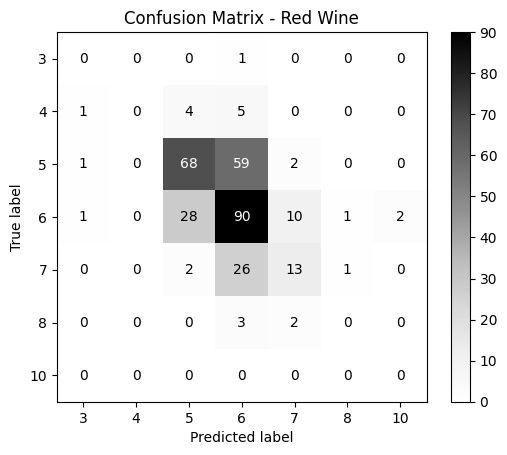

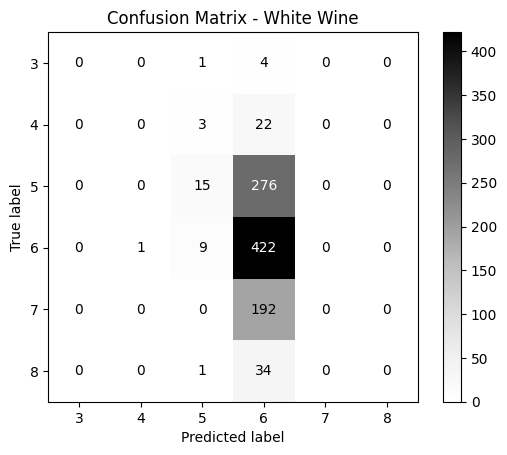

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix for Red Wine Model
cm_red = confusion_matrix(y_red_test_classes, y_red_wine_pred_classes)

# Generate confusion matrix for White Wine Model
cm_white = confusion_matrix(y_white_test_classes, y_white_wine_pred_classes, labels=np.unique(y_white_test_classes)) # add labels paramter

# Display confusion matrices
# Get the unique class labels from both the true and predicted values
# This ensures all possible classes are included in the labels
unique_labels_red = np.unique(np.concatenate((y_red_test_classes, y_red_wine_pred_classes)))

disp_red = ConfusionMatrixDisplay(confusion_matrix=cm_red, display_labels=unique_labels_red)
disp_red.plot(include_values=True, cmap='Greys', ax=None, xticks_rotation='horizontal')
plt.title("Confusion Matrix - Red Wine")
plt.show()
print("\n\n")

disp_white = ConfusionMatrixDisplay(confusion_matrix=cm_white, display_labels=np.unique(y_white_test_classes))
disp_white.plot(include_values=True, cmap='Greys', ax=None, xticks_rotation='horizontal')
plt.title("Confusion Matrix - White Wine")
plt.show()

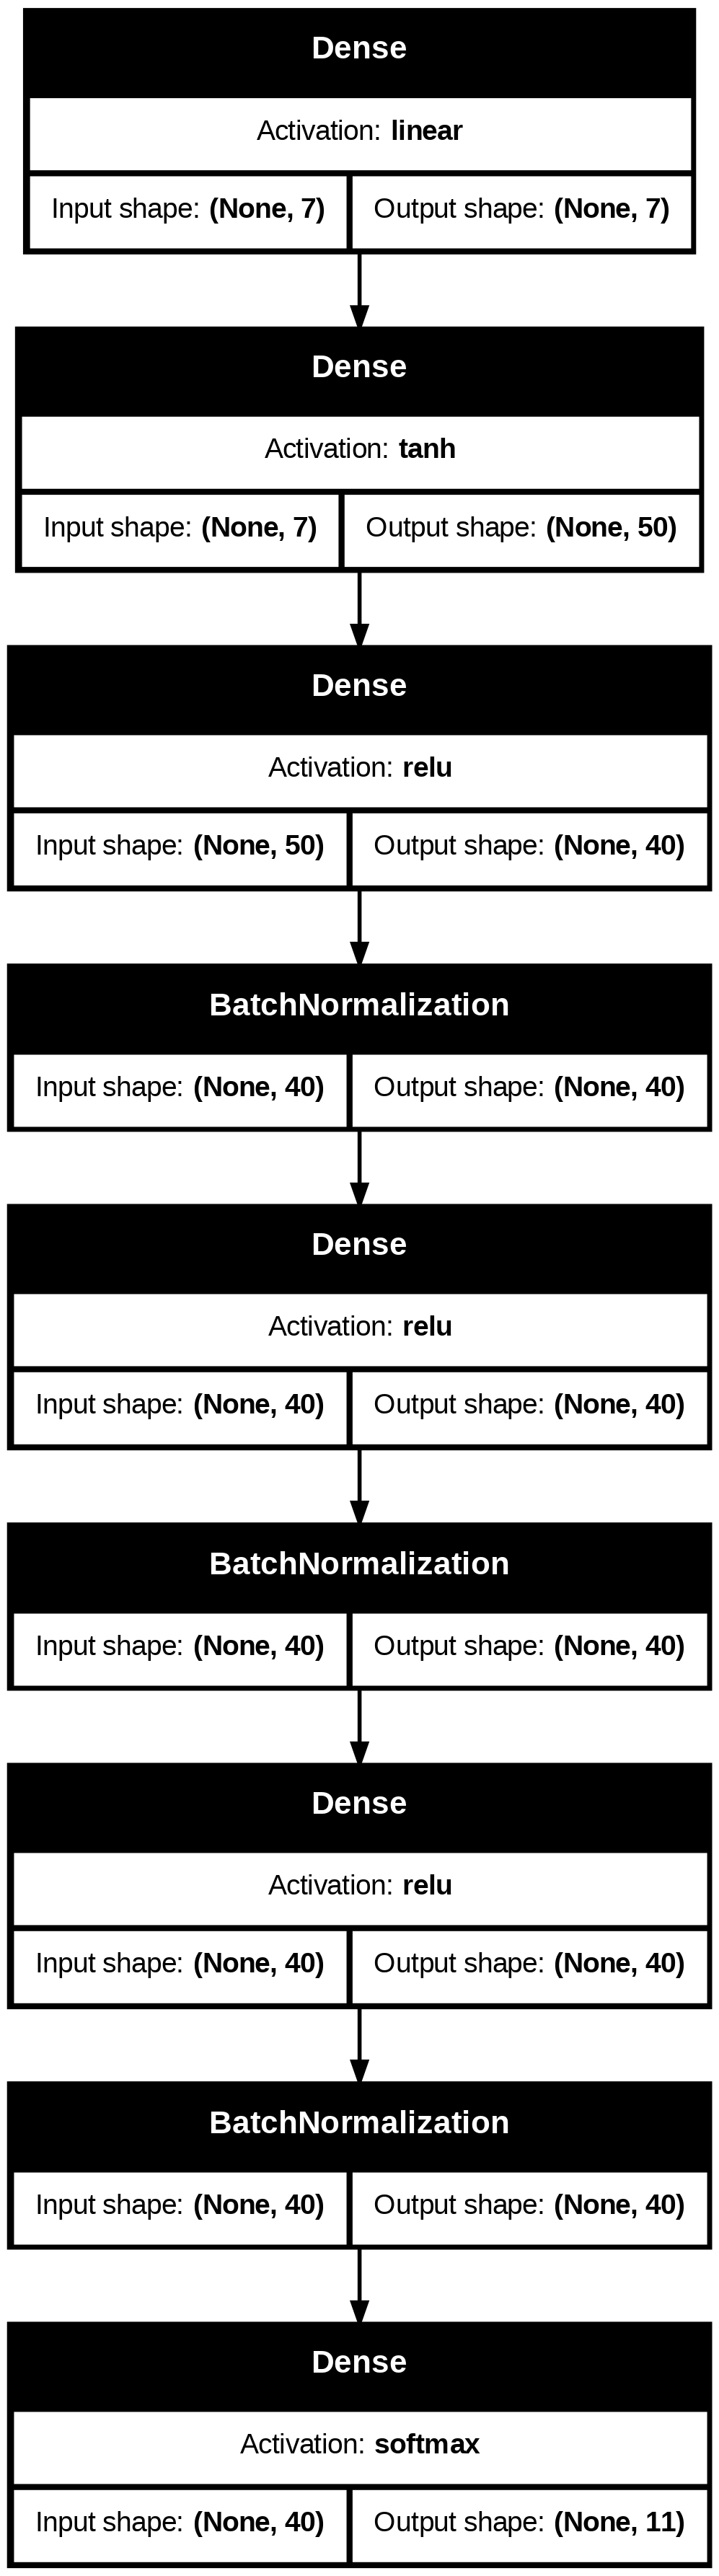

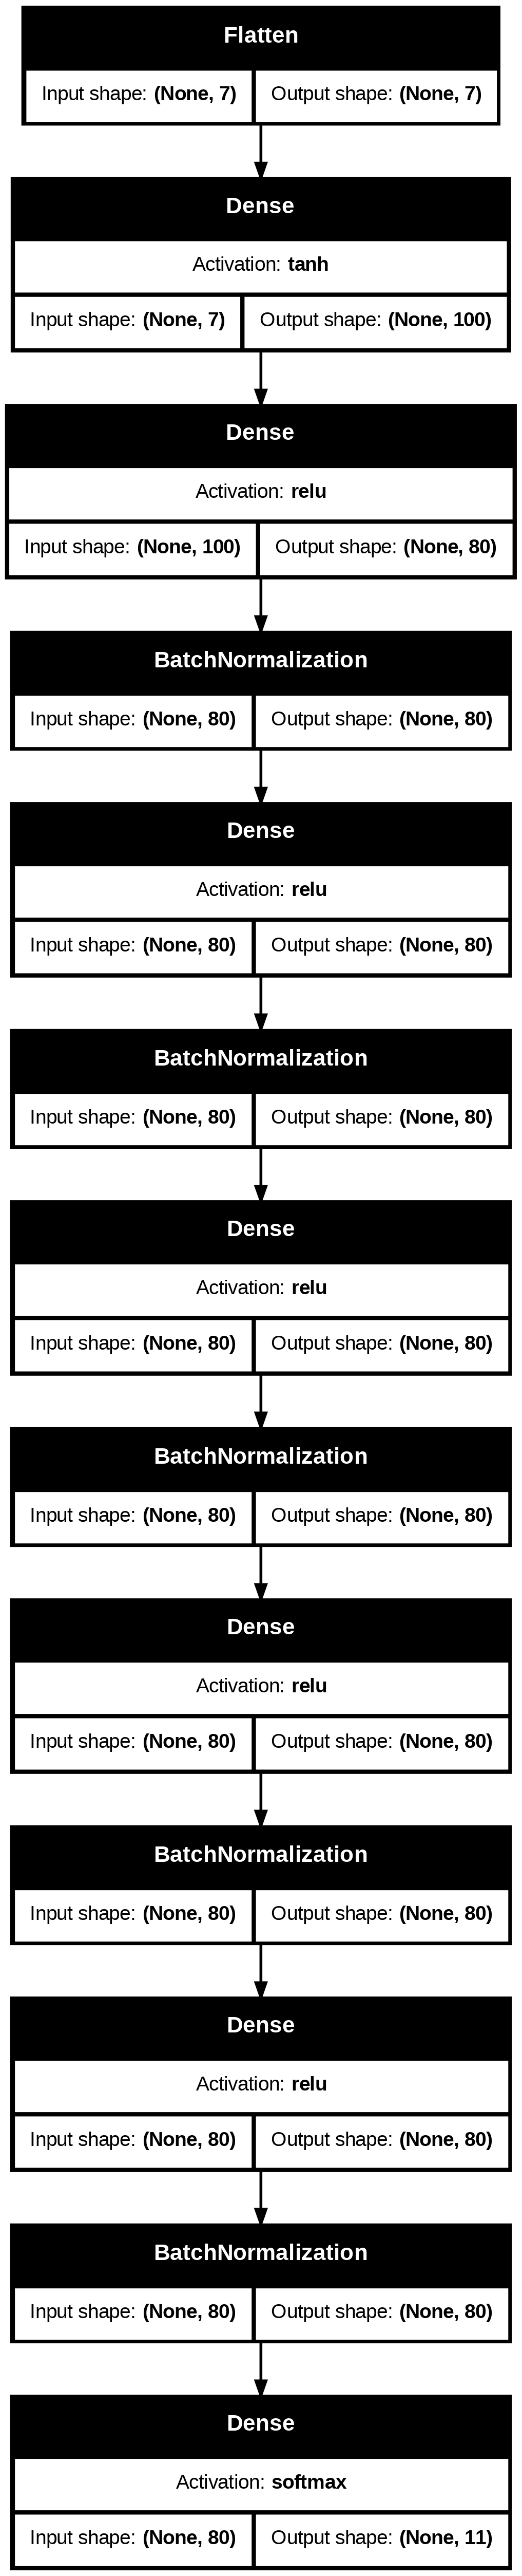

In [54]:
# prompt: visualize the models architectures

import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image

def plot_model_architecture(model):
    image = tf.keras.utils.plot_model(model,
                                      show_shapes=True,
                                      show_layer_activations=True,
                                      expand_nested=True, to_file=f'{model.name}.png')
    display(image)

plot_model_architecture(red_wine_model)
plot_model_architecture(white_wine_model)